# Comparación de Métodos de Super Resolución: Interpolacion Tradicional a Redes Neuronales

# Tabla de Contenidos

- [Comparación de Métodos de Super Resolución: Interpolacion Tradicional a Redes Generativas](#Comparación-de-Métodos-de-Super-Resolución:-Interpolacion-Tradicional-a-Redes-Generativas)
- [Metricas de Evaluación](#Metricas-de-Evaluación)
  - [PSNR (Peak Signal-to-Noise Ratio)](#PSNR-(Peak-Signal-to-Noise-Ratio))
  - [SSIM (Structural Similarity Index)](#SSIM-(Structural-Similarity-Index))
  - [Pérdida Perceptual](#Pérdida-Perceptual)
- [Métodos de Interpolación](#Métodos-de-Interpolación)
  - [Interpolación con 0's](#Interpolación-con-0's)
  - [Enventanado en 2 dimensiones](#Enventanado-en-2-dimensiones)
    - [Ventana de Kaiser](#Ventana-de-Kaiser)
    - [Ventana de Hann](#Ventana-de-Hann)
  - [Interpolación Lineal](#Interpolación-Lineal)
  - [Interpolación Bilineal](#Interpolación-Bilineal)
  - [Interpolación Cúbica](#Interpolación-Cúbica)
  - [Interpolación Bicúbica](#Interpolación-Bicúbica)
  - [Aplicación de GANs a la Super resolución](#Aplicación-de-GANs-a-la-Super-resolución)
- [Metodología](#Metodología)
  - [Dataset](#Dataset)
  - [Implementación de Métodos](#Implementación-de-Métodos)
  - [Evaluación de métodos FFT2D con ventanas Kaiser y Hann, Interpolación bilineal y bicubica](#Evaluación-de-métodos-FFT2D-con-ventanas-Kaiser-y-Hann,-Interpolación-bilineal-y-bicubica)
- [Resultados](#Resultados)
  - [Tabla](#Tabla)
  - [Plots](#Plots)
- [Conclusiones](#Conclusiones)
  - [PSNR](#PSNR)
  - [SSIM](#SSIM)
  - [Perceptual Loss](#Perceptual-Loss)
  - [Tiempo](#Tiempo)
  - [Implicaciones y Futuros Estudios](#Implicaciones-y-Futuros-Estudios)


La mejora de la resolución de imágenes es un desafío clave en el procesamiento de imágenes y la visión por computadora. La super resolución permite generar imágenes de alta resolución a partir de versiones de baja resolución, es esencial para aplicaciones como medicina, imágenes satelitales y fotografía digital. Tradicionalmente, se ha abordado con técnicas de interpolación y transformada de Fourier, pero estas tienen limitaciones en la preservación de detalles finos. Recientemente, las redes neuronales profundas y las Redes Generativas Antagónicas (GANs) han revolucionado el campo, generando imágenes de alta calidad y realismo. Este estudio explora y compara diversas técnicas de super resolución, desde métodos clásicos hasta modelos avanzados basados en GANs, analizando su desempeño, la calidad de imagen recuperada y el tiempo de procesamiento.

# Metricas de Evaluación

## PSNR (Peak Signal-to-Noise Ratio)

El PSNR (Peak Signal-to-Noise Ratio) es una métrica de evaluación ampliamente utilizada para medir la calidad de la reconstrucción de una imagen en comparación con la imagen original. El PSNR se define como la relación entre el valor máximo posible de un píxel y la potencia del ruido que afecta la fidelidad de su representación. Se expresa en decibelios (dB).

La fórmula para calcular el PSNR es la siguiente:

$$
PSNR = 10 \log_{10} \left( \frac{MAX_I^2}{MSE} \right) 
$$

donde $ MAX_I $ es el valor máximo del píxel de la imagen (por ejemplo, 255 para una imagen de 8 bits) y $ MSE $ es el error cuadrático medio entre la imagen original y la imagen generada. El MSE se define como:

$$
MSE = \frac{1}{MN} \sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \left[ I(i,j) - K(i,j) \right]^2
$$

Aquí, $ I(i,j) $ representa el valor del píxel en la posición \((i,j)\) de la imagen original y $ K(i,j) $ representa el valor del píxel en la misma posición de la imagen procesada. $ M $ y $ N $ son las dimensiones de las imágenes.

Un valor más alto de PSNR indica una mayor calidad de la imagen, ya que significa que hay menos diferencia entre la imagen original y la imagen generada. En general, un PSNR por encima de 30 dB se considera una buena calidad de imagen en la mayoría de las aplicaciones de super resolución.

El PSNR tiene la ventaja de ser simple y fácil de calcular, pero tiene la desventaja de que no siempre correlaciona bien con la percepción visual humana de la calidad de la imagen. Por esta razón, se utilizan otras métricas complementarias, como SSIM (Structural Similarity Index), para una evaluación más completa.

In [1]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = 1.0
    return 10 * np.log10((max_pixel ** 2) / mse)

## SSIM (Structural Similarity Index)
El SSIM (Structural Similarity Index) es una métrica de evaluación que mide la similitud entre dos imágenes. A diferencia del PSNR, que se basa en diferencias absolutas entre los valores de los píxeles, el SSIM considera cambios en la estructura, luminancia y contraste de la imagen, lo que lo hace más consistente con la percepción visual humana.

El SSIM se calcula utilizando una ventana y se define como:

$$
SSIM(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

donde $ x $ e $ y $ son las ventanas de la imagen original y la imagen recuperada, respectivamente. Los términos $\mu_x$ y $\mu_y$ son las medias de $x$ e $y$, $\sigma_x^2$ y $\sigma_y^2$ son las varianzas de $x$ e $y$, y $\sigma_{xy}$ es la covarianza entre $x$ e $y$. Los términos $C_1$ y $C_2$ son constantes para estabilizar la división y se definen como:

$$
C_1 = (K_1 L)^2 \quad \text{y} \quad C_2 = (K_2 L)^2
$$

donde $L$ es el rango dinámico de los valores de píxel y $K_1$ y $K_2$ son constantes pequeñas. El SSIM global para la imagen completa se obtiene promediando los valores de SSIM calculados para todas las ventanas:

$$
SSIM(I, K) = \frac{1}{M} \sum_{j=1}^{M} SSIM(x_j, y_j)
$$

donde $M$ es el número total de ventanas.

El SSIM varía entre -1 y 1, donde 1 indica imágenes idénticas, y valores más cercanos a 1 indican mayor similitud estructural. A diferencia del PSNR, el SSIM es más robusto para capturar la percepción humana de la calidad de la imagen, ya que tiene en cuenta las características estructurales y contextuales de las imágenes. 

Adicionalmente, se explica la métrica con redes neuronales de Perdida Perceptual.

In [2]:
import cv2
import numpy as np

def calculate_ssim(img1, img2):
    C1 = (0.01 ** 2)
    C2 = (0.03 ** 2)
    
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = cv2.GaussianBlur(img1 ** 2, (11, 11), 1.5) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(img2 ** 2, (11, 11), 1.5) - mu2_sq
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5) - mu1_mu2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

## Pérdida Perceptual
A diferencia de las métricas tradicionales como PSNR y SSIM, que se basan en diferencias de píxeles o estructuras, la pérdida perceptual mide la similitud entre las imágenes utilizando características extraídas de redes neuronales preentrenadas, como la red VGG.

La pérdida perceptual se define utilizando una red neuronal profunda preentrenada en una tarea de clasificación, las capas intermedias de esta red extraen características de alto nivel que capturan información semántica y estructural de las imágenes. La pérdida perceptual se calcula como la diferencia entre estas características para la imagen original y la imagen generada, se define como:

$$
L_{\text{perceptual}}(I_{\text{HR}}, I_{\text{SR}}) = \sum_{l} \frac{1}{N_l} \left\| \phi_l(I_{\text{HR}}) - \phi_l(I_{\text{SR}}) \right\|_2^2
$$

donde $ I_{\text{HR}} $ es la imagen de alta resolución real, $ I_{\text{SR}} $ es la imagen superresuelta generada, $ \phi_l $ representa la salida de la capa $ l $ de la red neuronal preentrenada, y $ N_l $ es el número de elementos en la salida de la capa $ l $.

Las características extraídas por la red preentrenada $\phi_l$ pueden capturar detalles de textura, bordes y otras estructuras importantes en las imágenes, lo que hace que la pérdida perceptual sea más sensible a las diferencias visuales que son perceptibles para el ojo humano. 

In [3]:
import numpy as np
from skimage import io, transform
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T

class VGGFeatures(nn.Module):
    def __init__(self, layers):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features[:layers].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.vgg(x)

def perceptual_loss(img1, img2, model):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)

    features1 = model(img1)
    features2 = model(img2)

    loss = nn.functional.mse_loss(features1, features2)
    return loss.item()

# Métodos de Interpolación

## Interpolación con 0's
Una técnica clásica de super resolución consiste en intercalar ceros en la imagen original, tomar la transformada rápida de Fourier en dos dimensiones (FFT2D), filtrar las frecuencias no deseadas y luego retornar al dominio del tiempo. Este método permite aumentar la resolución de la imagen de manera más precisa.

El primer paso en este proceso es la intercalación de ceros. Esto implica tomar la imagen de baja resolución y añadir ceros entre sus píxeles. Si tenemos una imagen $F$ de tamaño $M \times N$, la nueva imagen $F'$ con ceros intercalados tendrá un tamaño mayor, por ejemplo al incrementar por 4, el nuevo tamaño será $4M \times 4N$.

A continuación, se aplica la transformada discreta de Fourier en dos dimensiones a la imagen con ceros intercalados, esto convierte la imagen del dominio espacial al dominio de la frecuencia, donde cada punto en la imagen transformada representa una frecuencia espacial. La ecuación para la transformada de Fourier en dos dimensiones es:

$$
\mathcal{F}_{2D}[F'(x, y)] = G'(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} F'(x, y) e^{-j2\pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

Después de la FFT2D, se aplica un filtro para eliminar las frecuencias no deseadas. Este paso es crucial porque al intercalar ceros, se introducen frecuencias altas que no estaban presentes en la imagen original y que pueden causar artefactos no deseados. Filtrando estas frecuencias, se puede mejorar la calidad de la imagen resultante, como se observa en la Figura 2. El filtro aplicado sería  un filtro paso bajo que atenúa las altas frecuencias no deseadas producidas por la interpolación.

## Enventanado en 2 dimensiones

En el contexto del filtrado en 2D, se utilizan diversas ventanas que determinan cómo se aplica el filtro. Entre las ventanas más empleadas se encuentran la ventana Kaiser y la ventana Hann.

El proceso de obtener un filtro en 2D a partir de uno en 1D se puede realizar mediante el producto externo (outer product). Dado un filtro en 1D $ w(x) $, el filtro en 2D $ W(x, y) $ se puede definir como:
$$
W(x, y) = w(x) \cdot w(y)
$$
donde $ W(x, y) $ es el filtro en 2D y $ w(x) $ y $ w(y) $ son los filtros en 1D aplicados a cada dimensión.


### Ventana de Kaiser

La ventana de Kaiser ofrece un control sobre el ancho de la banda de transición y rizado a través de un parámetro $\beta$. La ventana de Kaiser en 1D se define como:
$$
w_{K}(x) = \frac{I_0 \left( \beta \sqrt{1 - \left( \frac{2x}{N-1} - 1 \right)^2} \right)}{I_0(\beta)}
$$
donde $ I_0 $ es la función modificada de Bessel de primer tipo, $ \beta $ es un parámetro ajustable y $ N $ es el tamaño del filtro.

Para obtener la ventana de Kaiser en 2D, se utiliza el producto externo:
$$
W_{K}(x, y) = w_{K}(x) \cdot w_{K}(y)
$$
donde $ w_{K}(x) $ es la ventana de Kaiser en 1D. La ecuación resultante en 2D es:
$$
W_{K}(x, y) = \frac{I_0 \left( \beta \sqrt{1 - \left( \frac{2x}{N-1} - 1 \right)^2} \right)}{I_0(\beta)} 
$$
$$
 \cdot \frac{I_0 \left( \beta \sqrt{1 - \left( \frac{2y}{N-1} - 1 \right)^2} \right)}{I_0(\beta)}
$$

### Ventana de Hann
La ventana de Hann, también conocida como ventana cosenoidal, es una de las ventanas más simples y se utiliza para reducir los efectos de discontinuidades en los bordes del segmento de datos. La ventana de Hann en 1D se define como:
$$
w_{H}(x) = 0.5 \left( 1 - \cos \left( \frac{2\pi x}{N-1} \right) \right)
$$
donde $ N $ es el tamaño del filtro.

Para extender la ventana de Hann a 2D, se utiliza el producto externo:
$$
W_{H}(x, y) = w_{H}(x) \cdot w_{H}(y)
$$
donde $ w_{H}(x) $ es la ventana de Hann en 1D. La ecuación resultante en 2D es:
$$
W_{H} = 0.5 \left( 1 - \cos \left( \frac{2\pi x}{N-1} \right) \right) \cdot 0.5 \left( 1 - \cos \left( \frac{2\pi y}{N-1} \right) \right)
$$

La elección de la ventana adecuada puede influir significativamente en el resultado final del proceso de super resolución.

In [4]:
import numpy as np

def hann_window_2d(rows, cols):
    x = np.arange(rows)
    y = np.arange(cols)
    hann_1d_x = 0.5 * (1 - np.cos(2 * np.pi * x / (rows - 1)))
    hann_1d_y = 0.5 * (1 - np.cos(2 * np.pi * y / (cols - 1)))
    hann_2d = np.outer(hann_1d_x, hann_1d_y)
    return hann_2d

def kaiser_window_2d(rows, cols, beta):
    x = np.arange(rows)
    y = np.arange(cols)
    kaiser_1d_x = i0(beta * np.sqrt(1 - ((2 * x / (rows - 1)) - 1) ** 2)) / i0(beta)
    kaiser_1d_y = i0(beta * np.sqrt(1 - ((2 * y / (cols - 1)) - 1) ** 2)) / i0(beta)
    kaiser_2d = np.outer(kaiser_1d_x, kaiser_1d_y)
    return kaiser_2d



Finalmente, se toma la transformada inversa de Fourier para retornar la imagen al dominio del tiempo (o espacial). Este paso convierte la imagen filtrada en el dominio de la frecuencia a una imagen de alta resolución en el dominio espacial. La ecuación para la transformada inversa de Fourier en dos dimensiones es:
$$
\mathcal{F}^{-1}_{2D}[G'(u,v)]=F'(x, y) 
$$

$$
F'(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} G'(u, v) e^{j2\pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
$$

El resultado es una imagen que, idealmente, tiene una mayor resolución y conserva los detalles de la imagen original.

Este enfoque, aunque menos sofisticado que las técnicas basadas en aprendizaje automático, puede ser efectivo y sencillo de implementar. Al combinar la intercalación de ceros con la transformada de Fourier y el filtrado de frecuencias, se puede mejorar la resolución de una imagen de manera significativa, destacando la flexibilidad y la utilidad de las técnicas de procesamiento de imágenes clásicas, sin embargo, se pierde información de las altas frecuencias.

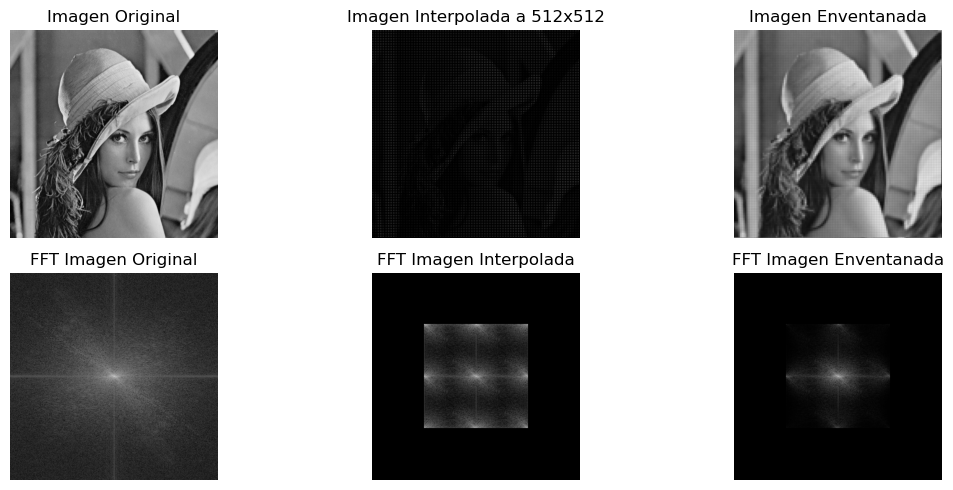

PSNR para enventanado: 6.620525829432813
SSIM para enventanado: 0.07533183974849478


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import cv2
from scipy.special import i0

url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
original_image = io.imread(url, as_gray=True)
low_res_image = transform.rescale(original_image, 1/4, anti_aliasing=True)

interpolated_image = np.zeros_like(original_image)
interpolated_image[::4, ::4] = low_res_image

original_freq_image = fft2(original_image)
original_freq_image_shifted = fftshift(original_freq_image)

freq_image = fft2(interpolated_image)
freq_image_shifted = fftshift(freq_image)

h, w = interpolated_image.shape
cutoff_x = w // 4
cutoff_y = h // 4
freq_image_shifted[:cutoff_y, :] = 0
freq_image_shifted[-cutoff_y:, :] = 0
freq_image_shifted[:, :cutoff_x] = 0
freq_image_shifted[:, -cutoff_x:] = 0

beta = 5
kaiser_window_small = kaiser_window_2d(cutoff_y * 2, cutoff_x * 2, beta)
kaiser_window = np.zeros((h, w))
kaiser_window[h//2-cutoff_y:h//2+cutoff_y, w//2-cutoff_x:w//2+cutoff_x] = kaiser_window_small
windowed_freq_image = freq_image_shifted * kaiser_window
windowed_image = np.abs(ifft2(ifftshift(windowed_freq_image)))

psnr_windowed = calculate_psnr(original_image, windowed_image)
ssim_windowed = calculate_ssim(original_image, windowed_image)

fig, axes = plt.subplots(2, 3, figsize=(12, 5))

axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title('Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(interpolated_image, cmap='gray')
axes[0, 1].set_title('Imagen Interpolada a 512x512')
axes[0, 1].axis('off')

axes[0, 2].imshow(windowed_image, cmap='gray')
axes[0, 2].set_title('Imagen Enventanada')
axes[0, 2].axis('off')

axes[1, 0].imshow(np.log(1 + np.abs(original_freq_image_shifted)), cmap='gray')
axes[1, 0].set_title('FFT Imagen Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.log(1 + np.abs(freq_image_shifted)), cmap='gray')
axes[1, 1].set_title('FFT Imagen Interpolada')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.log(1 + np.abs(windowed_freq_image)), cmap='gray')
axes[1, 2].set_title('FFT Imagen Enventanada')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"PSNR para enventanado: {psnr_windowed}")
print(f"SSIM para enventanado: {ssim_windowed}")


## Interpolación Lineal

La interpolación lineal es una técnica para encontrar nuevos puntos dentro del rango de un conjunto discreto de puntos conocidos. En una dimensión (1D), si tenemos dos puntos conocidos $(x_0, y_0)$ y $(x_1, y_1)$, el valor interpolado $y$ en un punto $x$ se puede calcular usando la fórmula:

$$
y = y_0 + \frac{(y_1 - y_0)}{(x_1 - x_0)} (x - x_0)
$$

Esta ecuación representa una línea recta que pasa por los puntos $(x_0, y_0)$ y $(x_1, y_1)$.

## Interpolación Bilineal

La interpolación bilineal extiende la interpolación lineal a dos dimensiones. Se utiliza para interpolar valores dentro de un cuadrado definido por cuatro puntos conocidos. Supongamos que queremos encontrar el valor interpolado en el punto $(x, y)$ dentro de una cuadrícula definida por los puntos $(x_1, y_1)$, $(x_2, y_1)$, $(x_1, y_2)$ y $(x_2, y_2)$. La ecuación de la interpolación bilineal es:

$$
f(x, y) \approx f(x_1, y_1) \frac{(x_2 - x)(y_2 - y)}{(x_2 - x_1)(y_2 - y_1)} + f(x_2, y_1) \frac{(x - x_1)(y_2 - y)}{(x_2 - x_1)(y_2 - y_1) }+ ...
$$


En esta ecuación, el valor interpolado $f(x, y)$ se calcula como una combinación ponderada de los valores en los cuatro puntos de la cuadrícula. Los pesos se basan en la distancia del punto $(x, y)$ a los puntos de la cuadrícula.



In [6]:
import numpy as np

def bilinear_interpolation(x, y, points):
    points = sorted(points)
    (x1, y1, q11), (x2, y2, q21), (x3, y3, q12), (x4, y4, q22) = points
    
    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 1e-9)

## Interpolación Cúbica

La interpolación cúbica es una técnica que utiliza polinomios cúbicos para interpolar entre puntos conocidos. En una dimensión (1D), la interpolación cúbica utiliza cuatro puntos $f(x_{-1}), f(x_0), f(x_1), f(x_2)$ para calcular el valor interpolado $f(x)$. La fórmula general para la interpolación cúbica es:

$$
f(x) = a + b(x - x_0) + c(x - x_0)^2 + d(x - x_0)^3
$$

donde los coeficientes $a, b, c, d$ se determinan a partir de los valores de los puntos conocidos y sus derivadas.

## Interpolación Bicúbica

La interpolación bicúbica es una extensión de la interpolación cúbica a dos dimensiones. Esta técnica proporciona una transición más suave entre los valores interpolados y es más precisa que la interpolación bilineal. La interpolación bicúbica utiliza 16 puntos de la cuadrícula circundante para calcular el valor interpolado en el punto $(x, y)$. La ecuación general para la interpolación bicúbica es:

$$
f(x, y) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} (x - x_0)^i (y - y_0)^j
$$

donde los coeficientes $a_{ij}$ se determinan a partir de los valores de la función y sus derivadas parciales en los puntos de la cuadrícula.

La interpolación bilineal y bicúbica son técnicas fundamentales en el procesamiento de imágenes y se utilizan en diversos algoritmos de super resolución para mejorar la calidad y la resolución de las imágenes.

In [11]:
def bicubic_interpolation(x, y, points):
    def cubic_interpolate(p, x):
        return p[1] + 0.5 * x*(p[2] - p[0] + x*(2.0*p[0] - 5.0*p[1] + 4.0*p[2] - p[3] + x*(3.0*(p[1] - p[2]) + p[3] - p[0])))
    
    arr = np.array(points)
    col0 = cubic_interpolate(arr[:,0], y)
    col1 = cubic_interpolate(arr[:,1], y)
    col2 = cubic_interpolate(arr[:,2], y)
    col3 = cubic_interpolate(arr[:,3], y)
    return cubic_interpolate([col0, col1, col2, col3], x)

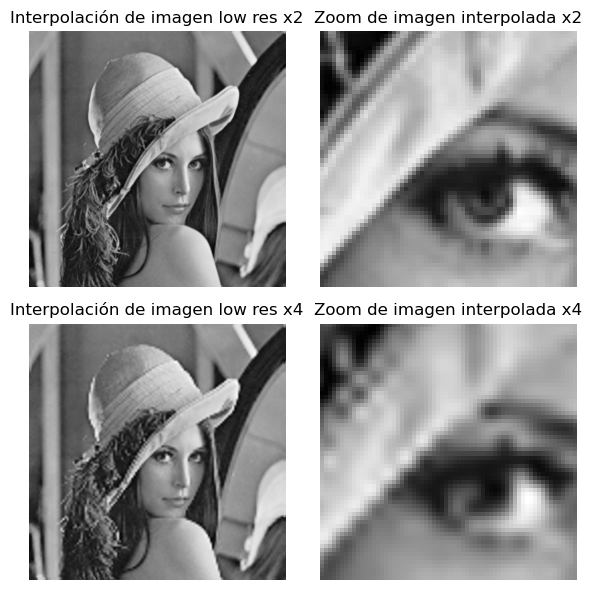

SSIM x2: 0.9061, PSNR x2: 32.67 dB
SSIM x4: 0.7879, PSNR x4: 26.75 dB


In [13]:
import numpy as np
import cv2
from skimage import io, img_as_float
import matplotlib.pyplot as plt

url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
original_image = img_as_float(io.imread(url, as_gray=True))
original_height, original_width = original_image.shape

low_res_2 = cv2.resize(original_image, (original_width // 2, original_height // 2), interpolation=cv2.INTER_LINEAR)
low_res_4 = cv2.resize(original_image, (original_width // 4, original_height // 4), interpolation=cv2.INTER_LINEAR)

low_res_2_up = np.zeros((original_height, original_width), dtype=original_image.dtype)
low_res_4_up = np.zeros((original_height, original_width), dtype=original_image.dtype)

src_height_2, src_width_2 = low_res_2.shape
src_height_4, src_width_4 = low_res_4.shape
ratio_x_2 = (src_width_2 - 1) / (original_width - 1)
ratio_y_2 = (src_height_2 - 1) / (original_height - 1)
ratio_x_4 = (src_width_4 - 1) / (original_width - 1)
ratio_y_4 = (src_height_4 - 1) / (original_height - 1)

for i in range(original_height):
    for j in range(original_width):
        x2 = j * ratio_x_2
        y2 = i * ratio_y_2
        x2_int = int(x2)
        y2_int = int(y2)
        x2_diff = x2 - x2_int
        y2_diff = y2 - y2_int

        if x2_int > 0 and x2_int < src_width_2 - 2 and y2_int > 0 and y2_int < src_height_2 - 2:
            points_2 = low_res_2[y2_int-1:y2_int+3, x2_int-1:x2_int+3]
            low_res_2_up[i, j] = bicubic_interpolation(x2_diff, y2_diff, points_2)
        else:
            low_res_2_up[i, j] = low_res_2[y2_int, x2_int]
        
        x4 = j * ratio_x_4
        y4 = i * ratio_y_4
        x4_int = int(x4)
        y4_int = int(y4)
        x4_diff = x4 - x4_int
        y4_diff = y4 - y4_int

        if x4_int > 0 and x4_int < src_width_4 - 2 and y4_int > 0 and y4_int < src_height_4 - 2:
            points_4 = low_res_4[y4_int-1:y4_int+3, x4_int-1:x4_int+3]
            low_res_4_up[i, j] = bicubic_interpolation(x4_diff, y4_diff, points_4)
        else:
            low_res_4_up[i, j] = low_res_4[y4_int, x4_int]

zoom_region_2_up = low_res_2_up[224:288, 224:288]
zoom_region_4_up = low_res_4_up[224:288, 224:288]

ssim_2 = calculate_ssim(original_image, low_res_2_up)
psnr_2 = calculate_psnr(original_image, low_res_2_up)
ssim_4 = calculate_ssim(original_image, low_res_4_up)
psnr_4 = calculate_psnr(original_image, low_res_4_up)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(low_res_2_up, cmap='gray')
axes[0, 0].set_title('Interpolación de imagen low res x2')
axes[0, 0].axis('off')

axes[0, 1].imshow(zoom_region_2_up, cmap='gray')
axes[0, 1].set_title('Zoom de imagen interpolada x2')
axes[0, 1].axis('off')

axes[1, 0].imshow(low_res_4_up, cmap='gray')
axes[1, 0].set_title('Interpolación de imagen low res x4')
axes[1, 0].axis('off')

axes[1, 1].imshow(zoom_region_4_up, cmap='gray')
axes[1, 1].set_title('Zoom de imagen interpolada x4')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"SSIM x2: {ssim_2:.4f}, PSNR x2: {psnr_2:.2f} dB")
print(f"SSIM x4: {ssim_4:.4f}, PSNR x4: {psnr_4:.2f} dB")


## Aplicación de GANs a la Super resolución

Además de los métodos clásicos basados en la FFT2D se consideran métodos modernos empleando GANs.

Para aplicar las GANs a la super resolución,  se considera el modelo SRGAN (Super-Resolution Generative Adversarial Network), se tiene el término de pérdida perceptual en la función de pérdida, además de la pérdida adversarial. La función de pérdida total se define como:

$$
L_{\text{SRGAN}} = L_{\text{content}} + \lambda L_{\text{adversarial}}
$$

Donde:
- $ L_{\text{content}} $ es la pérdida de contenido, que mide la diferencia entre la imagen generada y la imagen de alta resolución real utilizando una métrica como la pérdida de MSE (error cuadrático medio) o la pérdida perceptual basada en características extraídas por una red preentrenada como VGG.
- $ L_{\text{adversarial}} $ es la pérdida adversarial derivada de la GAN, que fomenta la generación de imágenes más realistas.
- $ \lambda $ es un hiperparámetro que equilibra las dos pérdidas.

La pérdida de contenido se puede definir como:

$$
L_{\text{content}} = \frac{1}{W H} \sum_{i=1}^{W} \sum_{j=1}^{H} \left\| I_{\text{HR}}(i,j) - G(I_{\text{LR}}(i,j)) \right\|_2^2
$$

donde $ I_{\text{HR}} $ es la imagen de alta resolución real, $ G(I_{\text{LR}}) $ es la imagen generada a partir de la imagen de baja resolución $ I_{\text{LR}} $, y $ W $ y $ H $ son el ancho y alto de la imagen, respectivamente.

La pérdida adversarial se define como:

$$
L_{\text{adversarial}} = -\log D(G(I_{\text{LR}}))
$$

La combinación de estas pérdidas permite al modelo SRGAN generar imágenes de alta resolución que no solo tienen alta calidad visual sino que también son perceptualmente agradables y realistas.



In [1]:
from easydict import EasyDict as edict
import json
import os
import time
import numpy as np
import tensorlayerx as tlx
from tensorlayerx.dataflow import Dataset, DataLoader
from srgan import SRGAN_g, SRGAN_d
from tensorlayerx.vision.transforms import Compose, RandomCrop, Normalize, RandomFlipHorizontal, Resize, HWC2CHW
import vgg
from tensorlayerx.model import TrainOneStep
from tensorlayerx.nn import Module
import cv2
from skimage import metrics
import torch
import torchvision.transforms as transforms
import torchvision.models as models

config = edict()
config.TRAIN = edict()
config.TRAIN.hr_img_path = 'DIV2K/DIV2K_train_HR/'
config.TRAIN.lr_img_path = 'DIV2K/DIV2K_train_LR_bicubic/X4/'

config.VALID = edict()
config.VALID.hr_img_path = 'DIV2K/DIV2K_valid_HR/'
config.VALID.lr_img_path = 'DIV2K/DIV2K_valid_LR_bicubic/X4/'

tlx.set_device('GPU')
save_dir = "samples"
tlx.files.exists_or_mkdir(save_dir)
checkpoint_dir = "models"
tlx.files.exists_or_mkdir(checkpoint_dir)

G = SRGAN_g()
D = SRGAN_d()
start_vgg_load_time = time.time()
VGG = vgg.VGG19(pretrained=True, end_with='pool4', mode='dynamic')
vgg_load_time = time.time() - start_vgg_load_time
print(f"VGG model load time: {vgg_load_time:.4f} seconds")
G.init_build(tlx.nn.Input(shape=(8, 3, 96, 96)))
D.init_build(tlx.nn.Input(shape=(8, 3, 384, 384)))
start_g_load_time = time.time()
G.load_weights(os.path.join(checkpoint_dir, 'g.npz'), format='npz_dict')
G.set_eval()
g_load_time = time.time() - start_g_load_time
print(f"G model load time: {g_load_time:.4f} seconds")
valid_hr_imgs = tlx.vision.load_images(path=config.VALID.hr_img_path)
transform = transforms.ToTensor()

def perceptual_loss(img1, img2):
    vgg16 = models.vgg16(weights=True).features[:16].eval()
    img1_tensor = transform(img1).unsqueeze(0).float()
    img2_tensor = transform(img2).unsqueeze(0).float()
    with torch.no_grad():
        img1_features = vgg16(img1_tensor)
        img2_features = vgg16(img2_tensor)
    return torch.nn.functional.mse_loss(img1_features, img2_features).item()

def evaluate_srgan():
    results = {'ssim': [], 'psnr': [], 'pl': [], 'time': []}
    for i in range(10):
        valid_hr_img = valid_hr_imgs[i]
        valid_lr_img = np.asarray(valid_hr_img)
        hr_size = [valid_lr_img.shape[0], valid_lr_img.shape[1]]
        valid_lr_img = cv2.resize(valid_lr_img, dsize=(hr_size[1] // 4, hr_size[0] // 4))
        valid_lr_img_tensor = (valid_lr_img / 127.5) - 1
        valid_lr_img_tensor = np.asarray(valid_lr_img_tensor, dtype=np.float32)
        valid_lr_img_tensor = np.transpose(valid_lr_img_tensor, axes=[2, 0, 1])
        valid_lr_img_tensor = valid_lr_img_tensor[np.newaxis, :, :, :]
        valid_lr_img_tensor = tlx.ops.convert_to_tensor(valid_lr_img_tensor)

        start_time = time.time()
        out = tlx.ops.convert_to_numpy(G(valid_lr_img_tensor))
        elapsed_time = time.time() - start_time

        out = np.asarray((out + 1) * 127.5, dtype=np.uint8)
        out = np.transpose(out[0], axes=[1, 2, 0])
        
        data_range = valid_hr_img.max() - valid_hr_img.min()
        ssim = metrics.structural_similarity(valid_hr_img, out, data_range=data_range, channel_axis=-1, win_size=7)
        psnr = metrics.peak_signal_noise_ratio(valid_hr_img, out, data_range=data_range)
        pl = perceptual_loss(valid_hr_img, out)

        results['ssim'].append(ssim)
        results['psnr'].append(psnr)
        results['pl'].append(pl)
        results['time'].append(elapsed_time)

        tlx.vision.save_image(out, file_name=f'valid_gen_{i}.png', path=save_dir)
        tlx.vision.save_image(valid_lr_img, file_name=f'valid_lr_{i}.png', path=save_dir)
        tlx.vision.save_image(valid_hr_img, file_name=f'valid_hr_{i}.png', path=save_dir)

    return results

def calculate_mean_and_variance(metrics_list):
    metrics_array = np.array(metrics_list)
    mean = np.mean(metrics_array)
    variance = np.var(metrics_array)
    return mean, variance

results = evaluate_srgan()

print("SRGAN Results:")
mean_ssim, var_ssim = calculate_mean_and_variance(results['ssim'])
mean_psnr, var_psnr = calculate_mean_and_variance(results['psnr'])
mean_pl, var_pl = calculate_mean_and_variance(results['pl'])
mean_time, var_time = calculate_mean_and_variance(results['time'])
print(f"SSIM: mean={mean_ssim:.4f}, variance={var_ssim:.4f}; PSNR: mean={mean_psnr:.2f}, variance={var_psnr:.2f}; Perceptual Loss: mean={mean_pl:.4f}, variance={var_pl:.4f}; Time: mean={mean_time:.4f}s, variance={var_time:.4f}s")


2024-07-19 17:31:47.307463: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 17:31:47.334240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using TensorFlow backend.
/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/tensorlayerx/__init__.py:45: UserWarning: The version of the backend you have installed does not match the specified backend version and may not work, please install version tensorflow 2.4.0.
  warnings.warn("The version of the backend you have installed does not match the specified backend vers

[TLX] [!] samples exists ...
[TLX] [!] models exists ...
[TLX] Conv2d conv2d_1: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: ReLU
[TLX] Conv2d conv2d_2: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_1: momentum: 0.900000 epsilon: 0.000010 act: ReLU is_train: True
[TLX] Conv2d conv2d_3: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_2: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_4: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_3: momentum: 0.900000 epsilon: 0.000010 act: ReLU is_train: True
[TLX] Conv2d conv2d_5: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_4: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_6: out_channels :

[TLX] Conv2d conv2d_43: out_channels : 2048 kernel_size: (4, 4) stride: (2, 2) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_38: momentum: 0.900000 epsilon: 0.000010 act: LeakyReLU is_train: True
[TLX] Conv2d conv2d_44: out_channels : 1024 kernel_size: (1, 1) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_39: momentum: 0.900000 epsilon: 0.000010 act: LeakyReLU is_train: True
[TLX] Conv2d conv2d_45: out_channels : 512 kernel_size: (1, 1) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_40: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_46: out_channels : 128 kernel_size: (1, 1) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_41: momentum: 0.900000 epsilon: 0.000010 act: LeakyReLU is_train: True
[TLX] Conv2d conv2d_47: out_channels : 128 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_42: momentum: 0.900000 epsilon: 0.0

2024-07-19 17:31:49.587651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-19 17:31:49.590634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-19 17:31:49.590717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[TLX]   Loading (3, 3, 3, 64) in conv1_1
[TLX]   Loading (64,) in conv1_1
[TLX]   Loading (3, 3, 64, 64) in conv1_2
[TLX]   Loading (64,) in conv1_2
[TLX]   Loading (3, 3, 64, 128) in conv2_1
[TLX]   Loading (128,) in conv2_1
[TLX]   Loading (3, 3, 128, 128) in conv2_2
[TLX]   Loading (128,) in conv2_2
[TLX]   Loading (3, 3, 128, 256) in conv3_1
[TLX]   Loading (256,) in conv3_1
[TLX]   Loading (3, 3, 256, 256) in conv3_2
[TLX]   Loading (256,) in conv3_2
[TLX]   Loading (3, 3, 256, 256) in conv3_3
[TLX]   Loading (256,) in conv3_3
[TLX]   Loading (3, 3, 256, 256) in conv3_4
[TLX]   Loading (256,) in conv3_4
[TLX]   Loading (3, 3, 256, 512) in conv4_1
[TLX]   Loading (512,) in conv4_1
[TLX]   Loading (3, 3, 512, 512) in conv4_2
[TLX]   Loading (512,) in conv4_2
[TLX]   Loading (3, 3, 512, 512) in conv4_3
[TLX]   Loading (512,) in conv4_3
[TLX]   Loading (3, 3, 512, 512) in conv4_4
[TLX]   Loading (512,) in conv4_4
VGG model load time: 0.6204 seconds
[TLX] Input  _inputlayer_1: (8, 3, 9

2024-07-19 17:31:50.377747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-07-19 17:31:50.416212: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[TLX] Input  _inputlayer_2: (8, 3, 384, 384)
[TLX] [*] Model restored from npz_dict models/g.npz
G model load time: 0.0514 seconds


/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SRGAN Results:
SSIM: mean=0.7349, variance=0.0152; PSNR: mean=26.97, variance=20.13; Perceptual Loss: mean=0.9151, variance=0.3229; Time: mean=0.1999s, variance=0.0360s


# Metodología

## Dataset
Para llevar a cabo los experimentos, se utilizó el conjunto de datos DIV2K, este conjunto de datos incluye imágenes en alta resolución con sus correspondientes versiones de baja resolución (LR), las cuales se generan mediante un proceso de degradación bicúbica.

Se seleccionaron imágenes específicamente del subconjunto de validación del dataset DIV2K para la evaluación, el cual se mantiene separado durante el entrenamiento de los modelos, asegurando así una evaluación imparcial y objetiva de los métodos de super resolución implementados.


## Implementación de Métodos
Los métodos implementados fueron los siguientes: Interpolación con filtro de Hann, Interpolación con filtro de Kaiser, Interpolación Lineal, Interpolación Bicúbica y SRGAN(Super-Resolution Generative Adversarial Network).

Para comparar la eficacia de estos métodos, se utilizaron diversas métricas de evaluación que permitieron medir el rendimiento de cada técnica de superresolución. Estas métricas proporcionaron una base sólida para analizar y contrastar los resultados obtenidos por cada método.

Los experimentos se realizaron sobre un conjunto de 10 imágenes de prueba. El proceso de evaluación incluye la super-resolución de las imágenes y la comparación de las imágenes resultantes con las originales mediante las métricas mencionadas.

## Evaluación de métodos FFT2D con ventanas Kaiser y Hann,  Interpolación bilineal y bicubica 

In [9]:
from skimage import io, img_as_float, img_as_ubyte
from skimage.transform import rescale
from skimage.filters import gaussian
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.special import i0
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
import time
import cv2
import torch.nn as nn
import torchvision.transforms as T
import json

N = 10
image_folder_path = 'test'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

def interpolate_with_window(image, scale_factor, window_type, beta=8):
    h, w = image.shape
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    interpolated_image = np.zeros((new_h, new_w))
    interpolated_image[::scale_factor, ::scale_factor] = image

    freq_image = fft2(interpolated_image)
    freq_image_shifted = fftshift(freq_image)

    cutoff_x = new_w // scale_factor
    cutoff_y = new_h // scale_factor
    freq_image_shifted[:cutoff_y, :] = 0
    freq_image_shifted[-cutoff_y:, :] = 0
    freq_image_shifted[:, :cutoff_x] = 0
    freq_image_shifted[:, -cutoff_x:] = 0

    if window_type == 'hann':
        window = hann_window_2d(cutoff_y * 2, cutoff_x * 2)
    elif window_type == 'kaiser':
        window = kaiser_window_2d(cutoff_y * 2, cutoff_x * 2, beta)
    else:
        raise ValueError("Tipo de ventana no reconocido.")

    window_full = np.zeros((new_h, new_w))
    window_full[new_h//2-cutoff_y:new_h//2+cutoff_y, new_w//2-cutoff_x:new_w//2+cutoff_x] = window
    windowed_freq_image = freq_image_shifted * window_full
    windowed_image = np.abs(ifft2(ifftshift(windowed_freq_image)))

    return windowed_image

def load_images(image_folder_path, N):
    images = []
    for i in range(N):
        image_path = os.path.join(image_folder_path, f'valid_hr_{i}.png')
        images.append(img_as_float(io.imread(image_path)))
    return images

original_images = load_images(image_folder_path, N)

def super_res_fft(image, scale_factor, window_type='hann'):
    channels = []
    for channel in range(image.shape[2]):
        img_channel = image[..., channel]
        high_res_channel = interpolate_with_window(img_channel, scale_factor, window_type)
        high_res_channel = gaussian(high_res_channel, sigma=0.5)
        high_res_channel = (high_res_channel - high_res_channel.min()) / (high_res_channel.max() - high_res_channel.min())
        channels.append(high_res_channel)
    
    high_res_image = np.stack(channels, axis=-1)
    return high_res_image

def save_image(image, index, method):
    output_path = os.path.join(output_dir, f'{index}_{method}.png')
    image_uint8 = img_as_ubyte(image)
    io.imsave(output_path, image_uint8)

def evaluate_results(original_image, low_res_image, scale_factor, method, index):
    start_time = time.time()
    if method in ['hann', 'kaiser']:
        super_res_image = super_res_fft(low_res_image, scale_factor, method)
    elif method == 'bilinear':
        super_res_image = rescale(low_res_image, scale_factor, order=1, channel_axis=-1)
    elif method == 'bicubic':
        super_res_image = rescale(low_res_image, scale_factor, order=3, channel_axis=-1)
    elapsed_time = time.time() - start_time

    save_image(super_res_image, index, method)

    ssim = calculate_ssim(original_image, super_res_image)
    psnr = calculate_psnr(original_image, super_res_image)
    
    vgg16 = VGGFeatures(layers=16).eval()
    
    perceptual_loss_value = perceptual_loss(original_image, super_res_image, vgg16)
    
    return ssim, psnr, perceptual_loss_value, elapsed_time

methods = ['hann', 'kaiser', 'bilinear', 'bicubic']
results = {method: {'ssim': [], 'psnr': [], 'pl': [], 'time': []} for method in methods}

for i in range(N):
    original_image = original_images[i]
    low_res_4 = rescale(original_image, 0.25, anti_aliasing=True, channel_axis=-1)
    
    for method in methods:
        ssim, psnr, pl, time_taken = evaluate_results(original_image, low_res_4, 4, method, i)
        results[method]['ssim'].append(ssim)
        results[method]['psnr'].append(psnr)
        results[method]['pl'].append(pl)
        results[method]['time'].append(time_taken)

def calculate_mean_and_variance(metrics_list):
    metrics_array = np.array(metrics_list)
    mean = np.mean(metrics_array)
    variance = np.var(metrics_array)
    return mean, variance

print("Mean and Variance Results:")
for method, metrics in results.items():
    mean_ssim, var_ssim = calculate_mean_and_variance(metrics['ssim'])
    mean_psnr, var_psnr = calculate_mean_and_variance(metrics['psnr'])
    mean_pl, var_pl = calculate_mean_and_variance(metrics['pl'])
    mean_time, var_time = calculate_mean_and_variance(metrics['time'])
    print(f"{method} - SSIM: mean={mean_ssim:.4f}, variance={var_ssim:.4f}; PSNR: mean={mean_psnr:.2f}, variance={var_psnr:.2f}; Perceptual Loss: mean={mean_pl:.4f}, variance={var_pl:.4f}; Time: mean={mean_time:.4f}s, variance={var_time:.4f}s")

results_file = 'results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Results saved to {results_file}")


/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean and Variance Results:
hann - SSIM: mean=0.6760, variance=0.0202; PSNR: mean=24.08, variance=6.70; Perceptual Loss: mean=0.6034, variance=0.0738; Time: mean=0.5136s, variance=0.0042s
kaiser - SSIM: mean=0.6695, variance=0.0203; PSNR: mean=24.10, variance=6.90; Perceptual Loss: mean=0.6809, variance=0.1015; Time: mean=0.5118s, variance=0.0038s
bilinear - SSIM: mean=0.7191, variance=0.0184; PSNR: mean=26.50, variance=12.80; Perceptual Loss: mean=0.3149, variance=0.0391; Time: mean=0.2844s, variance=0.0007s
bicubic - SSIM: mean=0.7460, variance=0.0168; PSNR: mean=27.29, variance=14.98; Perceptual Loss: mean=0.1269, variance=0.0090; Time: mean=1.8121s, variance=0.0292s
Results saved to results.json


# Resultados

In [10]:
from easydict import EasyDict as edict
import json
import os
import time
import numpy as np
import tensorlayerx as tlx
from tensorlayerx.dataflow import Dataset, DataLoader
from srgan import SRGAN_g, SRGAN_d
from tensorlayerx.vision.transforms import Compose, RandomCrop, Normalize, RandomFlipHorizontal, Resize, HWC2CHW
import vgg
from tensorlayerx.model import TrainOneStep
from tensorlayerx.nn import Module
import cv2
import torch
import torchvision.transforms as T
import torchvision.models as models
import torch.nn as nn

N = 10

config = edict()
config.TRAIN = edict()
config.TRAIN.hr_img_path = 'DIV2K/DIV2K_train_HR/'
config.TRAIN.lr_img_path = 'DIV2K/DIV2K_train_LR_bicubic/X4/'

config.VALID = edict()
config.VALID.hr_img_path = 'DIV2K/DIV2K_valid_HR/'
config.VALID.lr_img_path = 'DIV2K/DIV2K_valid_LR_bicubic/X4/'

tlx.set_device('GPU')

checkpoint_dir = "models"
output_dir = "outputs"
tlx.files.exists_or_mkdir(checkpoint_dir)
tlx.files.exists_or_mkdir(output_dir)

G = SRGAN_g()
D = SRGAN_d()
start_vgg_load_time = time.time()
VGG = vgg.VGG19(pretrained=True, end_with='pool4', mode='dynamic')
vgg_load_time = time.time() - start_vgg_load_time
print(f"VGG model load time: {vgg_load_time:.4f} seconds")

G.init_build(tlx.nn.Input(shape=(8, 3, 96, 96)))
D.init_build(tlx.nn.Input(shape=(8, 3, 384, 384)))

start_g_load_time = time.time()
G.load_weights(os.path.join(checkpoint_dir, 'g.npz'), format='npz_dict')
G.set_eval()
g_load_time = time.time() - start_g_load_time
print(f"G model load time: {g_load_time:.4f} seconds")

valid_hr_imgs = tlx.vision.load_images(path=config.VALID.hr_img_path)

transform = T.ToTensor()

def evaluate_srgan():
    results = {'ssim': [], 'psnr': [], 'pl': [], 'time': []}
    vgg_model = VGGFeatures(layers=16)
    for i in range(N):
        valid_hr_img = valid_hr_imgs[i]
        valid_lr_img = np.asarray(valid_hr_img)
        hr_size = [valid_lr_img.shape[0], valid_lr_img.shape[1]]
        valid_lr_img = cv2.resize(valid_lr_img, dsize=(hr_size[1] // 4, hr_size[0] // 4))
        valid_lr_img_tensor = (valid_lr_img / 127.5) - 1 
        valid_lr_img_tensor = np.asarray(valid_lr_img_tensor, dtype=np.float32)
        valid_lr_img_tensor = np.transpose(valid_lr_img_tensor, axes=[2, 0, 1])
        valid_lr_img_tensor = valid_lr_img_tensor[np.newaxis, :, :, :]
        valid_lr_img_tensor = tlx.ops.convert_to_tensor(valid_lr_img_tensor)

        start_time = time.time()
        out = tlx.ops.convert_to_numpy(G(valid_lr_img_tensor))
        elapsed_time = time.time() - start_time

        out = np.asarray((out + 1) * 127.5, dtype=np.uint8)
        out = np.transpose(out[0], axes=[1, 2, 0])
        
        data_range = valid_hr_img.max() - valid_hr_img.min()
        ssim = calculate_ssim(valid_hr_img, out)
        psnr = calculate_psnr(valid_hr_img / 255.0, out / 255.0) 
        pl = perceptual_loss(valid_hr_img, out, vgg_model)

        results['ssim'].append(ssim)
        results['psnr'].append(psnr)
        results['pl'].append(pl)
        results['time'].append(elapsed_time)

        tlx.vision.save_image(out, path=output_dir, file_name=f'{i}_srgan.png')
        tlx.vision.save_image(valid_lr_img, path=output_dir, file_name=f'{i}_linear.png')
        tlx.vision.save_image(valid_hr_img, path=output_dir, file_name=f'{i}_hr.png')

    return results

results_file = 'results.json'
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        previous_results = json.load(f)
else:
    previous_results = {}

if 'srgan' not in previous_results:
    previous_results['srgan'] = {'ssim': [], 'psnr': [], 'pl': [], 'time': []}

srgan_results = evaluate_srgan()
previous_results['srgan']['ssim'].extend(srgan_results['ssim'])
previous_results['srgan']['psnr'].extend(srgan_results['psnr'])
previous_results['srgan']['pl'].extend(srgan_results['pl'])
previous_results['srgan']['time'].extend(srgan_results['time'])

print("Mean and Variance Results:")
for method, metrics in previous_results.items():
    mean_ssim, var_ssim = calculate_mean_and_variance(metrics['ssim'])
    mean_psnr, var_psnr = calculate_mean_and_variance(metrics['psnr'])
    mean_pl, var_pl = calculate_mean_and_variance(metrics['pl'])
    mean_time, var_time = calculate_mean_and_variance(metrics['time'])
    print(f"{method} - SSIM: mean={mean_ssim:.4f}, variance={var_ssim:.4f}; PSNR: mean={mean_psnr:.2f}, variance={var_psnr:.2f}; Perceptual Loss: mean={mean_pl:.4f}, variance={var_pl:.4f}; Time: mean={mean_time:.4f}s, variance={var_time:.4f}s")

with open(results_file, 'w') as f:
    json.dump(previous_results, f, indent=4)
print(f"Results saved to {results_file}")


2024-07-19 20:52:55.651465: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 20:52:55.673301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[TLX] [!] models exists ...
[TLX] [!] outputs exists ...
[TLX] Conv2d conv2d_1: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: ReLU
[TLX] Conv2d conv2d_2: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_1: momentum: 0.900000 epsilon: 0.000010 act: ReLU is_train: True
[TLX] Conv2d conv2d_3: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_2: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_4: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_3: momentum: 0.900000 epsilon: 0.000010 act: ReLU is_train: True
[TLX] Conv2d conv2d_5: out_channels : 64 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_4: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_6: out_channels :

Using TensorFlow backend.
/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/tensorlayerx/__init__.py:45: UserWarning: The version of the backend you have installed does not match the specified backend version and may not work, please install version tensorflow 2.4.0.
  warnings.warn("The version of the backend you have installed does not match the specified backend version "
2024-07-19 20:52:56.719438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-19 20:52:56.722784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torv

[TLX] BatchNorm batchnorm2d_33: momentum: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TLX] Conv2d conv2d_35: out_channels : 256 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] SubpixelConv2d  subpixelconv2d_1: scale: 2 act: ReLU
[TLX] Conv2d conv2d_36: out_channels : 256 kernel_size: (3, 3) stride: (1, 1) pad: SAME act: No Activation
[TLX] SubpixelConv2d  subpixelconv2d_2: scale: 2 act: ReLU
[TLX] Conv2d conv2d_37: out_channels : 3 kernel_size: (1, 1) stride: (1, 1) pad: SAME act: Tanh
[TLX] Conv2d conv2d_38: out_channels : 64 kernel_size: (4, 4) stride: (2, 2) pad: SAME act: LeakyReLU
[TLX] Conv2d conv2d_39: out_channels : 128 kernel_size: (4, 4) stride: (2, 2) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_34: momentum: 0.900000 epsilon: 0.000010 act: LeakyReLU is_train: True
[TLX] Conv2d conv2d_40: out_channels : 256 kernel_size: (4, 4) stride: (2, 2) pad: SAME act: No Activation
[TLX] BatchNorm batchnorm2d_35: momentum: 0.900000 eps

2024-07-19 20:52:57.496677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-07-19 20:52:57.542808: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[TLX] Input  _inputlayer_2: (8, 3, 384, 384)
[TLX] [*] Model restored from npz_dict models/g.npz
G model load time: 0.0496 seconds


/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dsplab/anaconda3/envs/cnn-tf/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean and Variance Results:
hann - SSIM: mean=0.6760, variance=0.0202; PSNR: mean=24.08, variance=6.70; Perceptual Loss: mean=0.6034, variance=0.0738; Time: mean=0.5136s, variance=0.0042s
kaiser - SSIM: mean=0.6695, variance=0.0203; PSNR: mean=24.10, variance=6.90; Perceptual Loss: mean=0.6809, variance=0.1015; Time: mean=0.5118s, variance=0.0038s
bilinear - SSIM: mean=0.7191, variance=0.0184; PSNR: mean=26.50, variance=12.80; Perceptual Loss: mean=0.3149, variance=0.0391; Time: mean=0.2844s, variance=0.0007s
bicubic - SSIM: mean=0.7460, variance=0.0168; PSNR: mean=27.29, variance=14.98; Perceptual Loss: mean=0.1269, variance=0.0090; Time: mean=1.8121s, variance=0.0292s
srgan - SSIM: mean=0.4071, variance=0.0115; PSNR: mean=27.06, variance=20.49; Perceptual Loss: mean=0.4797, variance=0.1105; Time: mean=0.1825s, variance=0.0313s
Results saved to results.json


## Tabla

In [11]:
import pandas as pd
import json
import numpy as np

results_file = 'results.json'
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        results = json.load(f)
        
def calculate_mean_std(data):
    means = {key: np.mean(values) for key, values in data.items()}
    stds = {key: np.std(values) for key, values in data.items()}
    return {'mean': means, 'std': stds}

results_mean_std = {}

for method, metrics in results.items():
    results_mean_std[method] = calculate_mean_std(metrics)

combined_data = {}
for model, metrics in results_mean_std.items():
    combined_data[model] = {metric: f"<span style='color:red'>{metrics['mean'][metric]:.4f}</span> ± <span style='color:blue'>{metrics['std'][metric]:.4f}</span>" for metric in metrics['mean'].keys()}

combined_df = pd.DataFrame(combined_data)
styled_df = combined_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
styled_df


## Plots

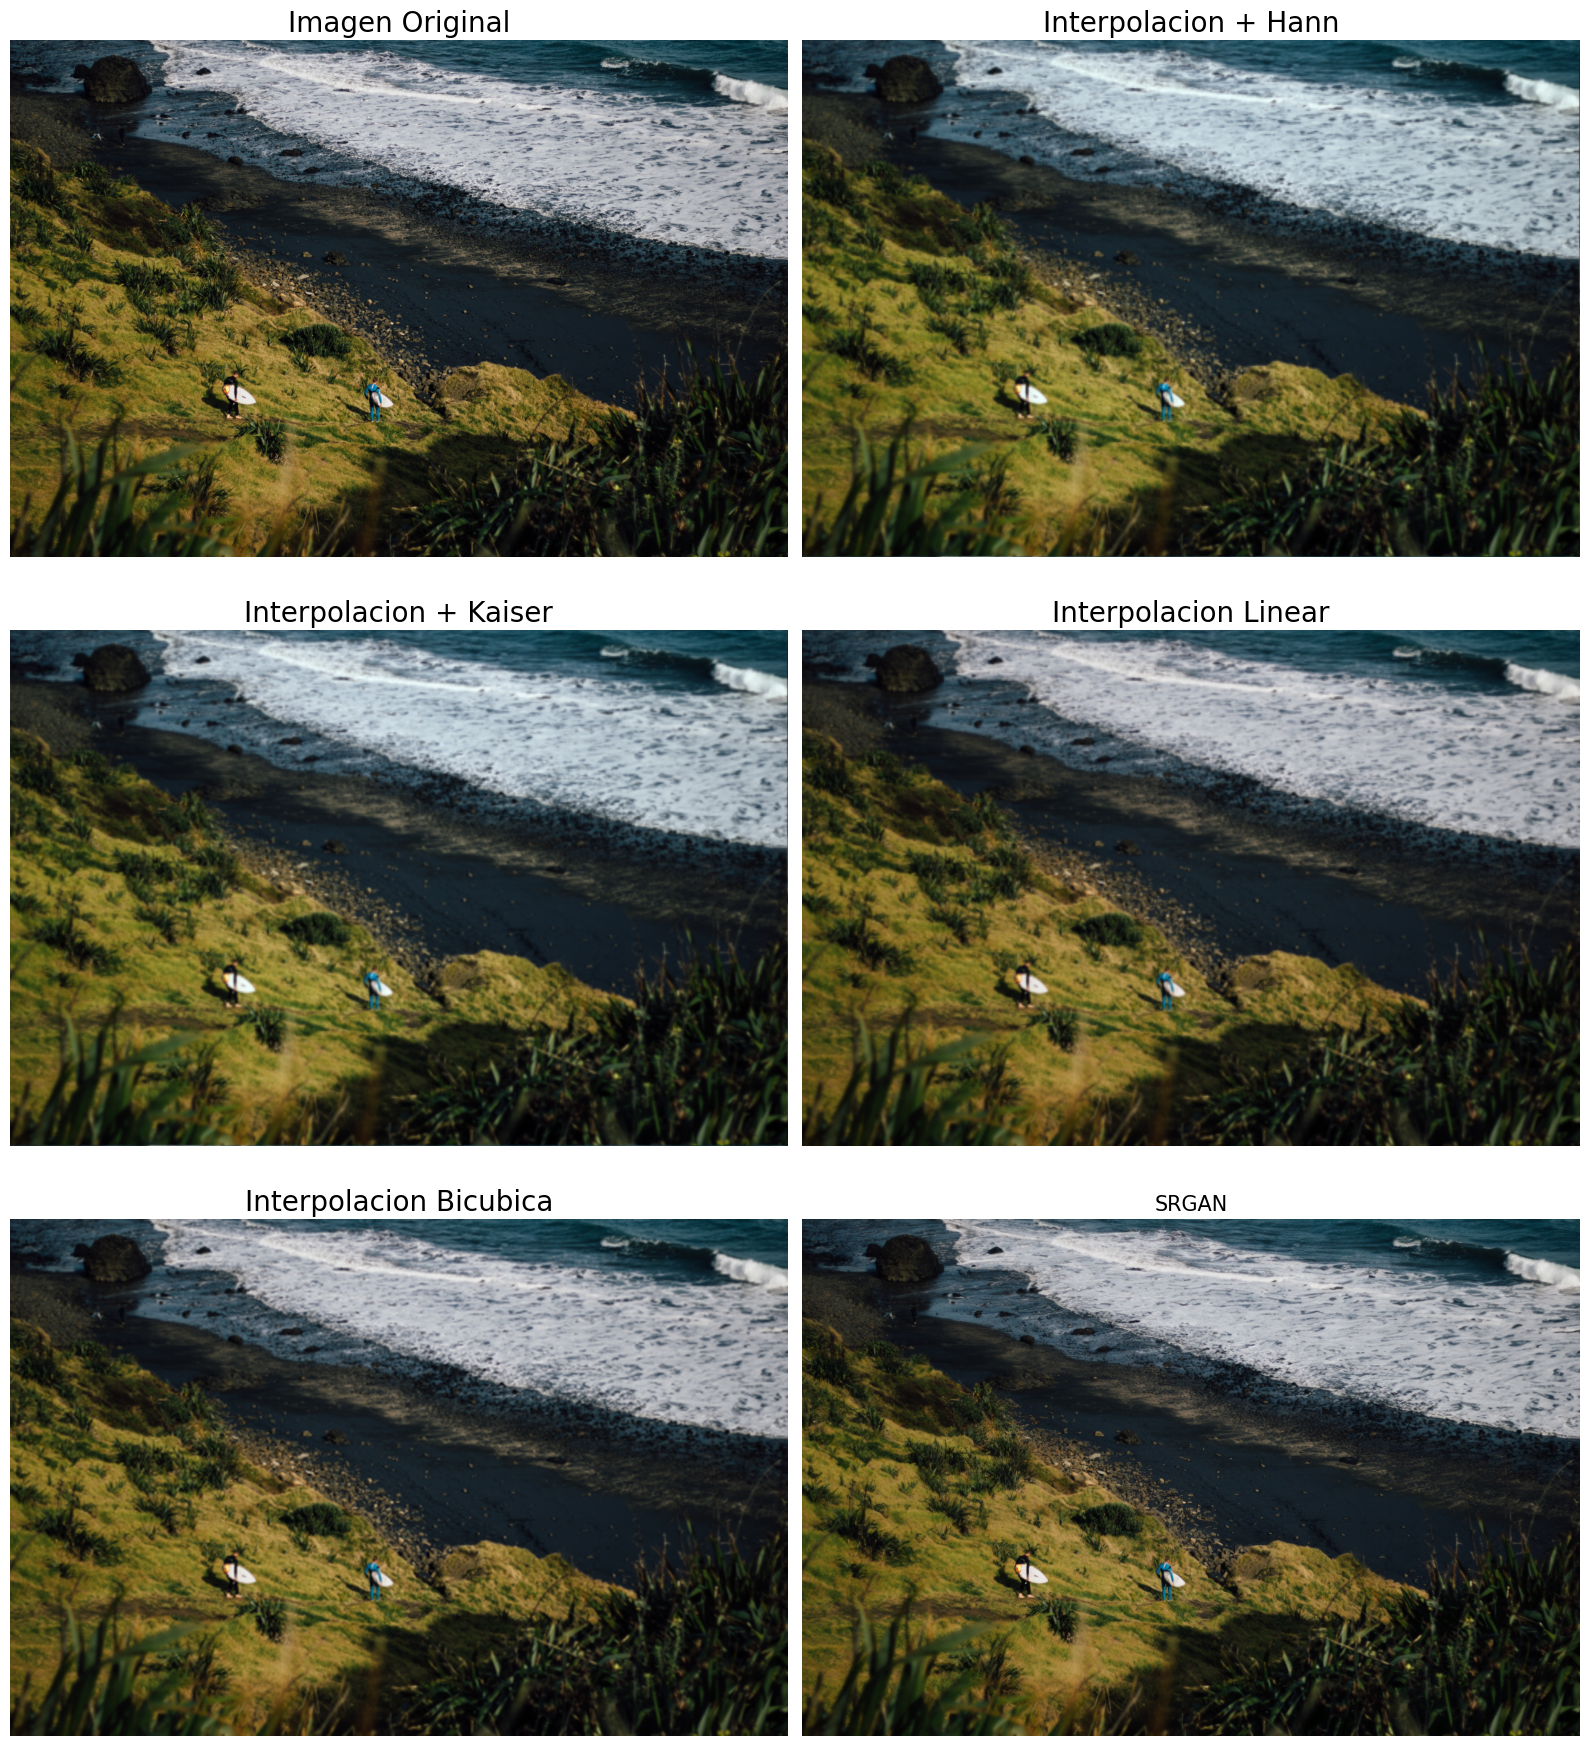

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

img_orig = mpimg.imread('outputs/9_orig.png')
img_linear = mpimg.imread('outputs/9_bilinear.png')
img_cubic = mpimg.imread('outputs/9_bicubic.png')
img_hann = mpimg.imread('outputs/9_hann.png')
img_kaiser = mpimg.imread('outputs/9_kaiser.png')
img_srgan = mpimg.imread('outputs/9_srgan.png')

fig = plt.figure(figsize=(16, 18))
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_orig)
ax1.set_title('Imagen Original', fontsize=20)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_hann)
ax2.set_title('Interpolacion + Hann', fontsize=20)
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 0])
ax3.imshow(img_kaiser)
ax3.set_title('Interpolacion + Kaiser', fontsize=20)
ax3.axis('off')

ax4 = fig.add_subplot(gs[1, 1])
ax4.imshow(img_linear)
ax4.set_title('Interpolacion Linear', fontsize=20)
ax4.axis('off')

ax5 = fig.add_subplot(gs[2, 0])
ax5.imshow(img_cubic)
ax5.set_title('Interpolacion Bicubica', fontsize=20)
ax5.axis('off')


ax6 = fig.add_subplot(gs[2, 1])
ax6.imshow(img_srgan)
ax6.set_title('SRGAN', fontsize=15)
ax6.axis('off')

plt.tight_layout()
plt.show()


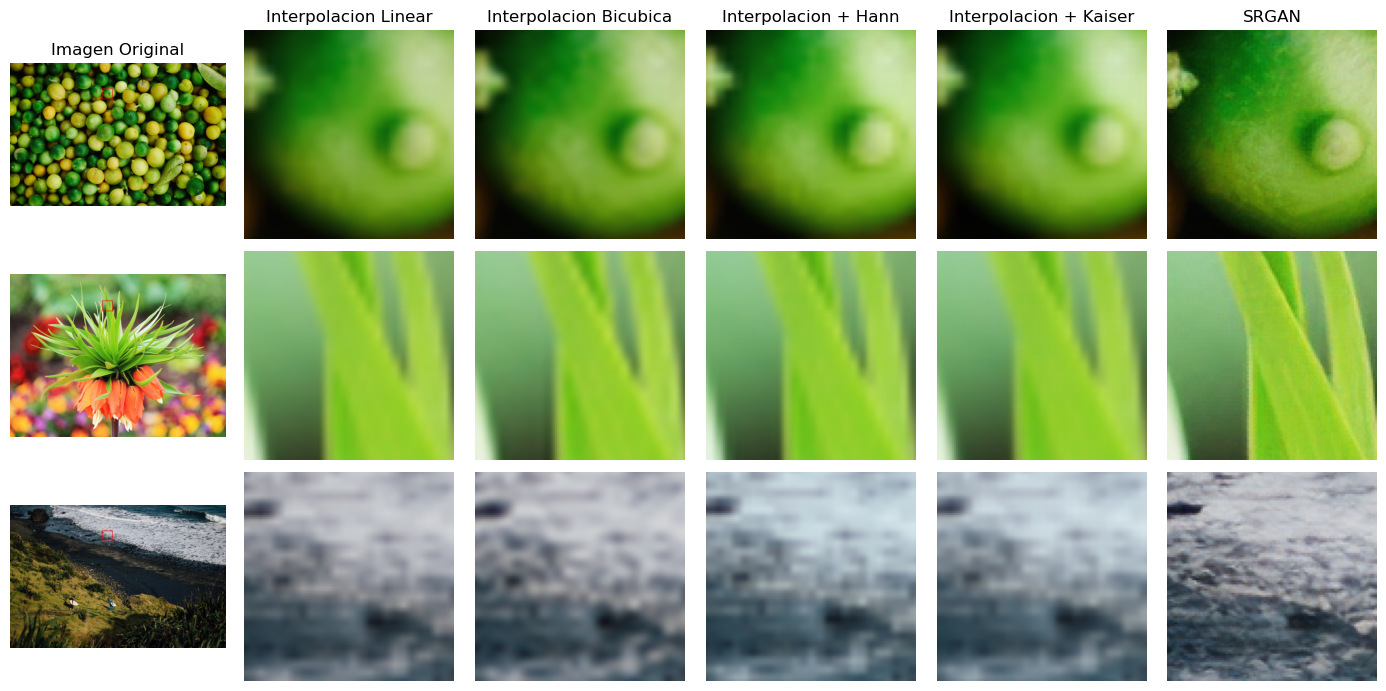

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw

orig_images = ['outputs/0_orig.png', 'outputs/1_orig.png', 'outputs/9_orig.png']
interpolations = [
    ['outputs/0_bilinear.png', 'outputs/0_bicubic.png', 'outputs/0_hann.png', 'outputs/0_kaiser.png', 'outputs/0_srgan.png'],
    ['outputs/1_bilinear.png', 'outputs/1_bicubic.png', 'outputs/1_hann.png', 'outputs/1_kaiser.png', 'outputs/1_srgan.png'],
    ['outputs/9_bilinear.png', 'outputs/9_bicubic.png',  'outputs/9_hann.png', 'outputs/9_kaiser.png', 'outputs/9_srgan.png']
]

titles = ["Imagen Original", "Interpolacion Linear", "Interpolacion Bicubica", "Interpolacion + Hann", "Interpolacion + Kaiser", "SRGAN"]
zoom_x, zoom_y = 870, 250
zoom_size = 100
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(14, 7))

for i in range(3):
    img = Image.open(orig_images[i])
    draw = ImageDraw.Draw(img)
    draw.rectangle([zoom_x, zoom_y, zoom_x + zoom_size, zoom_y + zoom_size], outline="red", width=5)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')

for i in range(3):
    for j in range(5):
        img = Image.open(interpolations[i][j])
        zoomed_area = img.crop((zoom_x, zoom_y, zoom_x + zoom_size, zoom_y + zoom_size))
        axes[i, j+1].imshow(zoomed_area)
        axes[i, j+1].axis('off')

for j in range(6):
    axes[0, j].set_title(titles[j])

plt.tight_layout()
plt.savefig('plot3.pdf', format='pdf', bbox_inches='tight')
plt.show()


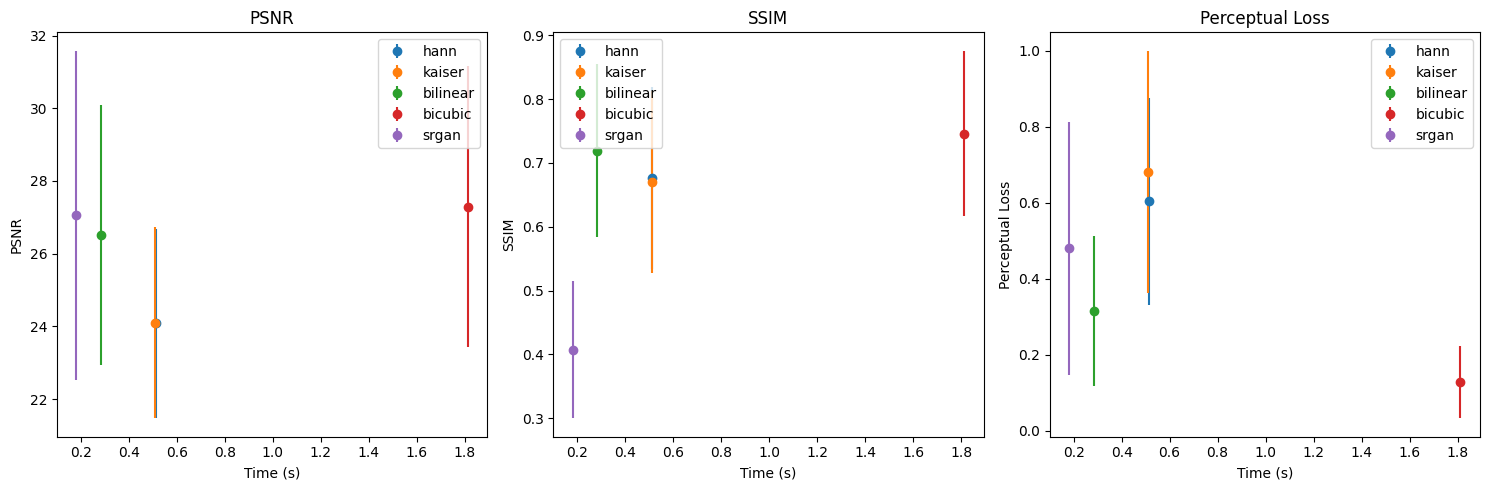

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json

with open('results.json', 'r') as f:
    results = json.load(f)

def calculate_mean_std(data):
    return {metric: {'mean': np.mean(values), 'std': np.std(values)} for metric, values in data.items()}

results_mean_std = {method: calculate_mean_std(metrics) for method, metrics in results.items()}
methods = ["hann", "kaiser", "bilinear", "bicubic", "srgan"]
metrics = ['psnr', 'ssim', 'pl', 'time']
data = {metric: {'mean': [], 'std': []} for metric in metrics}

for method in methods:
    for metric in metrics:
        if metric in results_mean_std[method]:
            data[metric]['mean'].append(results_mean_std[method][metric]['mean'])
            data[metric]['std'].append(results_mean_std[method][metric]['std'])
        else:
            data[metric]['mean'].append(np.nan)
            data[metric]['std'].append(np.nan)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
titles = ["PSNR", "SSIM", "Perceptual Loss"]
y_labels = ["PSNR", "SSIM", "Perceptual Loss"]

for i, metric in enumerate(['psnr', 'ssim', 'pl']):
    for j, method in enumerate(methods):
        axs[i].errorbar(data['time']['mean'][j], data[metric]['mean'][j], 
                        yerr=data[metric]['std'][j], fmt='o', label=method)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(y_labels[i])
    axs[i].legend(loc='best')

plt.tight_layout()
plt.savefig('plot4.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Conclusiones

En esta sección se evalúan los resultados luego de evaluar los diversos métodos de resolución, se emplearán las métricas presentadas.

Debido a que las imágenes fueron reducidas en dimensionalidad empleando el método bicúbico, al interpolar con el mismo método bicúbico, este es el que mejores resultados tiene en la reconstrucción de las 3 métricas.

## PSNR

Los resultados de PSNR muestran que el modelo bicúbico, como lo anterior mencionado, tiene los mejores resultados. Sin embargo, esta ventaja viene acompañada de un tiempo de procesamiento significativamente mayor. En contraste, las ventanas de Hann y Kaiser presentaron los valores de PSNR más bajos, lo que indica una menor capacidad para preservar los detalles finos de las imágenes originales. SRGAN obtuvo los mejores resultados luego del método bicúbico en PSNR.

## SSIM

En términos de SSIM, la interpolación bicúbica demostró ser el método más efectivo, mostrando una alta similitud estructural con las imágenes originales, sin embargo, nuevamente este método fue el más lento. Las técnicas de enventanado, como Hann y Kaiser, mostraron los SSIM más bajos luego de SRGAN, reflejando una menor capacidad para mantener la estructura de las imágenes en comparación con los métodos de interpolación espacial. SRGAN tuvo el menor en comparación, indicando una menor similitud estructural con las imágenes originales, lo cual se da debido a que el modelo de redes neuronales "crea" píxeles dependiendo del modelo que haya sido entrenado, por ello también se considera el Perceptual Loss.

## Perceptual Loss

El Perceptual Loss evaluó cómo de similares son las imágenes generadas a las originales desde una perspectiva visual. La interpolación bicúbica tuvo el menor Perceptual Loss debido a que la decimación de las imágenes se dio con el mismo método. Las técnicas de enventanado resultaron menos efectivas en esta métrica, presentando los valores más altos de Perceptual Loss y destacando una menor calidad perceptual. SRGAN tuvo el mejor rendimiento luego de la interpolación bicúbica, ello se puede comprobar además en las imágenes adjuntas, en las cuales se puede apreciar visualmente que se recuperan los detalles originales.

## Tiempo

SRGAN fue uno de los métodos más rápidos en general, considerando su tiempo de carga del modelo y de los pesos preentrenados y que además el procesamiento se dio en la GPU. La interpolación lineal fue el método más rápido sin necesidad de carga adicional, haciendo de ella una opción viable para aplicaciones donde la velocidad es crítica. Por otro lado, la interpolación bicúbica fue la más lenta, lo que puede ser un obstáculo para su uso en aplicaciones en tiempo real.

## Conclusiones generales

Los resultados obtenidos sugieren que, para aplicaciones donde la calidad visual es primordial, los modelos basados en GANs como SRGAN son la mejor opción (sin considerar interpolacion bicubica debido a que la decimacion se dio por este metodo).

## Trabajos Futuros

Las futuras investigaciones podrían enfocarse en mejorar la consistencia y reducir la varianza de los modelos basados en GANs, así como en la optimización de técnicas clásicas para aplicaciones específicas.
